# International Debt

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import wbgapi as wb
from notion_client import APIResponseError
import seaborn as sns
import math
import sklearn

ModuleNotFoundError: No module named 'sklearn'

Get the indicators and values for all the countries using the workd bank api

In [6]:
# GNI per capita year on year (%) = NY.GNP.PCAP.KD.ZG
# GDP growth year on year (%) = NY.GDP.MKTP.KD.ZG
# GDP per capita (current US$) = NY.GDP.PCAP.CD

# Functions to get indicator data for a country and to return it in formatted JSON
def get_indicator_list(indicator,country_code):
    indicator_list = {}
    try:
        for row in wb.data.fetch(indicator, country_code): # all years
            year = row['time'][2:]
            if(int(year) > 2020 or int(year) < 2000): continue
            if row['value'] != None:
                indicator_list[row['time'][2:]] = row['value']
            else:
                indicator_list[row['time'][2:]] = np.nan
    except APIResponseError as err:
        print(f"An APIRespsonse error occured with {country_code} : {err}")
    except Exception as err:
        print(f"An unexpected error occured: {err}")

    return indicator_list

def get_indicatiors_for_country(country_code):
    indicators_data = {'GNI per capita year on year (%)': get_indicator_list('NY.GNP.PCAP.KD.ZG',country_code),
                       'GDP growth year on year (%)': get_indicator_list('NY.GDP.MKTP.KD.ZG',country_code),
                       'GDP per capita (current US$)': get_indicator_list('NY.GDP.PCAP.CD',country_code)}
    return indicators_data


In [5]:
# Get all the country codes for all the countries
with open(f'./IDS_ALLCountries_Data.json') as f:
    data = json.load(f)
country_codes = []
for i in data:
    country_code = i['Country Code']
    if country_code in country_codes or country_code == '' : continue
    country_codes.append(country_code)

In [3]:
# Send all the countries indicator data to the directory 'indicators_for_countries_data' as json.
for country_code in country_codes:
    indicator_json = {country_code: get_indicatiors_for_country(country_code)}
    with open(f"indicators_for_countries_data/{country_code}_indicators", "w") as outfile:
        json.dump(indicator_json, outfile)


NameError: name 'country_codes' is not defined

In [25]:
# Functions to get indicator data for all the countries in the dataset

# Sorts indicator data into dictionaries given a countries code
def get_indicator_data_ready(country_code):
    
    # Opens the json that has the data for the indicators for the given country
    with open(f"./indicators_data/{country_code}_indicators") as f:
        json_indicators = json.load(f)
    
    country_ind_data = {}

    # Creates a country_indicator key and value pair inside of the dictionary that cointains all of the country indicators data e.g. {country_indicator: "SDN", GNI_data:[...], ...}
    country_ind_data["country_indicator"] = country_code

    # For each indicators data in the dictionary of all indicators it appends the value of the indicator in the given year in order 2000-2020
    indicators_dict = json_indicators[country_code]

    for indicator in indicators_dict:
        sorted_year_arr = []
        individual_data = indicators_dict[indicator]
    
        for year in individual_data:

            # Gets the value in the curremt year then appends it to an array containg all the current indicators data
            value = individual_data[year]
            sorted_year_arr.append(value)

        # Adds the indicator do the dictionary with its corresponding values
        country_ind_data[indicator] = sorted_year_arr
    
    # Returns the total dictionary
    return country_ind_data

# Gets a table for the indicators data for a specific year
def get_incicator_table(year):

    data_array = []
    column_names = []

    # Gets the keys for the general indicators json by getting the key from the first indicator
    for country_ind_key in get_indicator_data_ready('AFG'):

        # If it is the "country_indicator" key and value pair it continues
        if country_ind_key == 'country_indicator': continue
        temp_data_array = []

        # For each individual country code it gets the indicator data and gets the specifc years data
        for individual_country_code in country_codes:
            data = get_indicator_data_ready(individual_country_code)
            temp_data_array.append(data[country_ind_key][year-2000])

        data_array.append(temp_data_array)
        column_names.append(country_ind_key)
    
    # Creates a pandas dataframe given the data
    df_ind = pd.DataFrame(np.array(data_array),index=column_names,columns=country_codes).T

    return df_ind

df_indicators_2010 = get_incicator_table(2010)

# Prints out the data of indicators for all countries in the specified dataset in 2002
df_indicators_2010

,GNI per capita year on year (%),GDP growth year on year (%),GDP per capita (current US$)
AFG,NaN,1.189228,502.057099
ALB,3.909938,4.019346,5287.660817
DZA,-1.677847,1.200000,4171.795309
AGO,-6.828785,-1.316362,2487.500996
ARG,-4.661284,-2.617396,11795.162885
...,...,...,...
VEN,NaN,NaN,NaN
VNM,7.501681,7.464991,3267.225009
YEM,NaN,0.752448,701.714878
ZMB,NaN,4.034494,1475.199836


Compare the values from all the categories (or a select few) from two different countries

In [9]:
# Function to extract data for a country. To get all the categories of data leave the selection empty - only put the country_code value
def split_data_up(country_code, selection=[]):
    with open(f'./countries_data/{country_code}') as f:
        total_data = json.load(f)

    years = []
    categories_and_values = {}

    # When the selection is an empty array then all of the categories are given
    if selection == []:
        for data in total_data:
            temp_values = []
            for year, value in data.items():
                if year == 'Category': continue
                if year not in years: years.append(year)
                temp_values.append(float(value) if value != '' else 0)
            categories_and_values[data['Category']] = temp_values       
    else:
        for data in total_data:
            # If the current data category is not in the selection given then it continues to the next category
            if data['Category'] not in selection: continue
            temp_values = []
            for year, value in data.items():
                if year == 'Category': continue
                if year not in years: years.append(year)
                temp_values.append(float(value) if value != '' else 0)
            categories_and_values[data['Category']] = temp_values

    return [years,categories_and_values,country_code]

In [41]:
def get_data_for_year(all_country_codes,year):
    year_data = {}
    for country in all_country_codes:
        country_year_data = {}
        with open(f'./countries_data/{country}') as f:
           country_data = json.load(f)
        for data_category in country_data:
            country_year_data[data_category['Category']] = data_category[str(year)]
        year_data[country] = country_year_data
    return {year:year_data}

def get_all_years_data(_country_codes):
    years_data = {}
    for i in range(21):
        years_data |= get_data_for_year(_country_codes,(i+2000))

    rearranged_years_data = {}
    for year in years_data:
        year_total_data = years_data[year]
        all_categories = {}
        for country_code in year_total_data:
            country_data = year_total_data[country_code]
            for data_category in country_data:
                if country_code == country_codes[0]: all_categories[data_category] = []
                all_categories[data_category].append(country_data[data_category])
        rearranged_years_data[year] = all_categories

    return rearranged_years_data

def get_rearranged_year_data(total_year_data, year):
    temp_country_codes = country_codes
    temp_data = []
    temp_column_names = []

    for temp_category in total_year_data[year]:
        temp_column_names.append(temp_category)
        temp_data.append(total_year_data[year][temp_category])

    df_categories = pd.DataFrame(np.array(temp_data), index=temp_column_names, columns=temp_country_codes).T

    return df_categories

all_years_data = get_all_years_data(country_codes)

df_example_2010 = get_rearranged_year_data(all_years_data, 2010)

df_example_2010


,Average grace period on new external debt commitments (years),Average grant element on new external debt commitments (%),Average maturity on new external debt commitments (years),Concessional debt (% of total external debt),Current account balance (current US$),"Exports of goods, services and primary income (current US$)","External debt stocks (% of exports of goods, services and primary income)",External debt stocks (% of GNI),"External debt stocks, long-term (DOD, current US$)","External debt stocks, short-term (DOD, current US$)",...,"Interest payments on external debt, public sector (PPG) (INT, current US$)","Interest payments on external debt, short-term (INT, current US$)","Interest payments on external debt, total (INT, current US$)",Short-term debt (% of total external debt),Total change in external debt stocks (current US$),"Total debt service (% of exports of goods, services and primary income)",Total reserves (% of total external debt),"Total reserves (includes gold, current US$)","Use of IMF credit (DOD, current US$)","Use of IMF credit, SDR allocations (DOD, current US$)"
AFG,7.8333,21.2119,25.3333,39.615,-577708206.8,2746604195,88.68569086,15.3347225,1975547214,105067801.3,...,7709000,979000,9465611.1,4.3134,-44369207.7,0.379800305,171.3724609,4174367358,355229891.1,239188630.6
ALB,4.5976,-2.4257,9.124,23.3942,-1355598479,3703040658,146.8137467,46.04447306,4564030111,743172000,...,66206728,7753000,118153543.8,13.6698,831409090,10.27592781,45.42471159,2469547484,129370620.5,71534793.9
DZA,0,0,0,7.7494,12220267767,65168162141,11.12962169,4.510071473,3629509110,1778220000,...,64268394.9,17988000,118782837.1,24.5171,-161322707.5,1.037612132,2242.040052,1.62614E+11,1845240799,1845240799
AGO,1.0037,4.8385,9.2189,4.8159,7505954235,51585764936,51.94373436,35.39115119,20925636702,4567673350,...,176668246.9,58626000,322214928.4,17.0463,6518291452,5.741132615,73.43997411,19678661657,1302262652,420441474.3
ARG,7.1409,19.2478,18.1574,0.3175,-1622995871,83888208133,150.9657194,30.95787408,1.07119E+11,16413011633,...,2699707492,150186000,3948977987,12.9601,-7052684340,18.64262334,39.27109343,49733869724,3110922140,3110922140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEN,19.6589,-29.1921,26.328,0.0677,5585000000,70481000000,165.3338656,30.00683223,88557095437,24055176043,...,3596874505,583334000,6869011914,20.643,22175707072,24.01648186,11.27341538,13136793906,3916690338,3916690338
VNM,7.6653,29.9613,23.1557,40.2466,-4276000000,80153000000,56.0679603,40.30045172,37478255716,6932477307,...,563314078.3,78640000,787388559.2,15.426,12198184200,2.345899635,27.74045035,12466600611,529419194.7,484789125.3
YEM,4.0069,24.357,17.1725,69.379,-1054136270,9325006299,69.75271505,22.36144613,5944744526,124193455.9,...,74204022.5,nan,75354682.9,1.9093,-294750946.2,2.755570717,90.22066772,5868353775,435507090.4,357673974.2
ZMB,5.8398,24.5483,23.3432,19.4052,1525082952,8062708256,52.74791531,22.49912519,1985803869,1150106702,...,11200735.8,30720000,62537312.9,27.0428,606546402.6,1.858137964,49.23106787,2093753266,1116999952,722485847.2


In [79]:
# Combine indicator table and category table

def get_corr_table_for_year(year):

    indicator_table = get_incicator_table(year)
    debt_categories_table = get_rearranged_year_data(all_years_data, year)

    dataframes = [indicator_table, debt_categories_table.reindex(indicator_table.index)]

    df_combined = pd.concat(dataframes,axis=1)
    
    df_corr = df_combined.corr()

    return df_corr

corr_11 = get_corr_table_for_year(2011)

print(type(corr_11))


<class 'pandas.core.frame.DataFrame'>


Creating the total correlation table between all the indicators and the categories of the average of all the countries

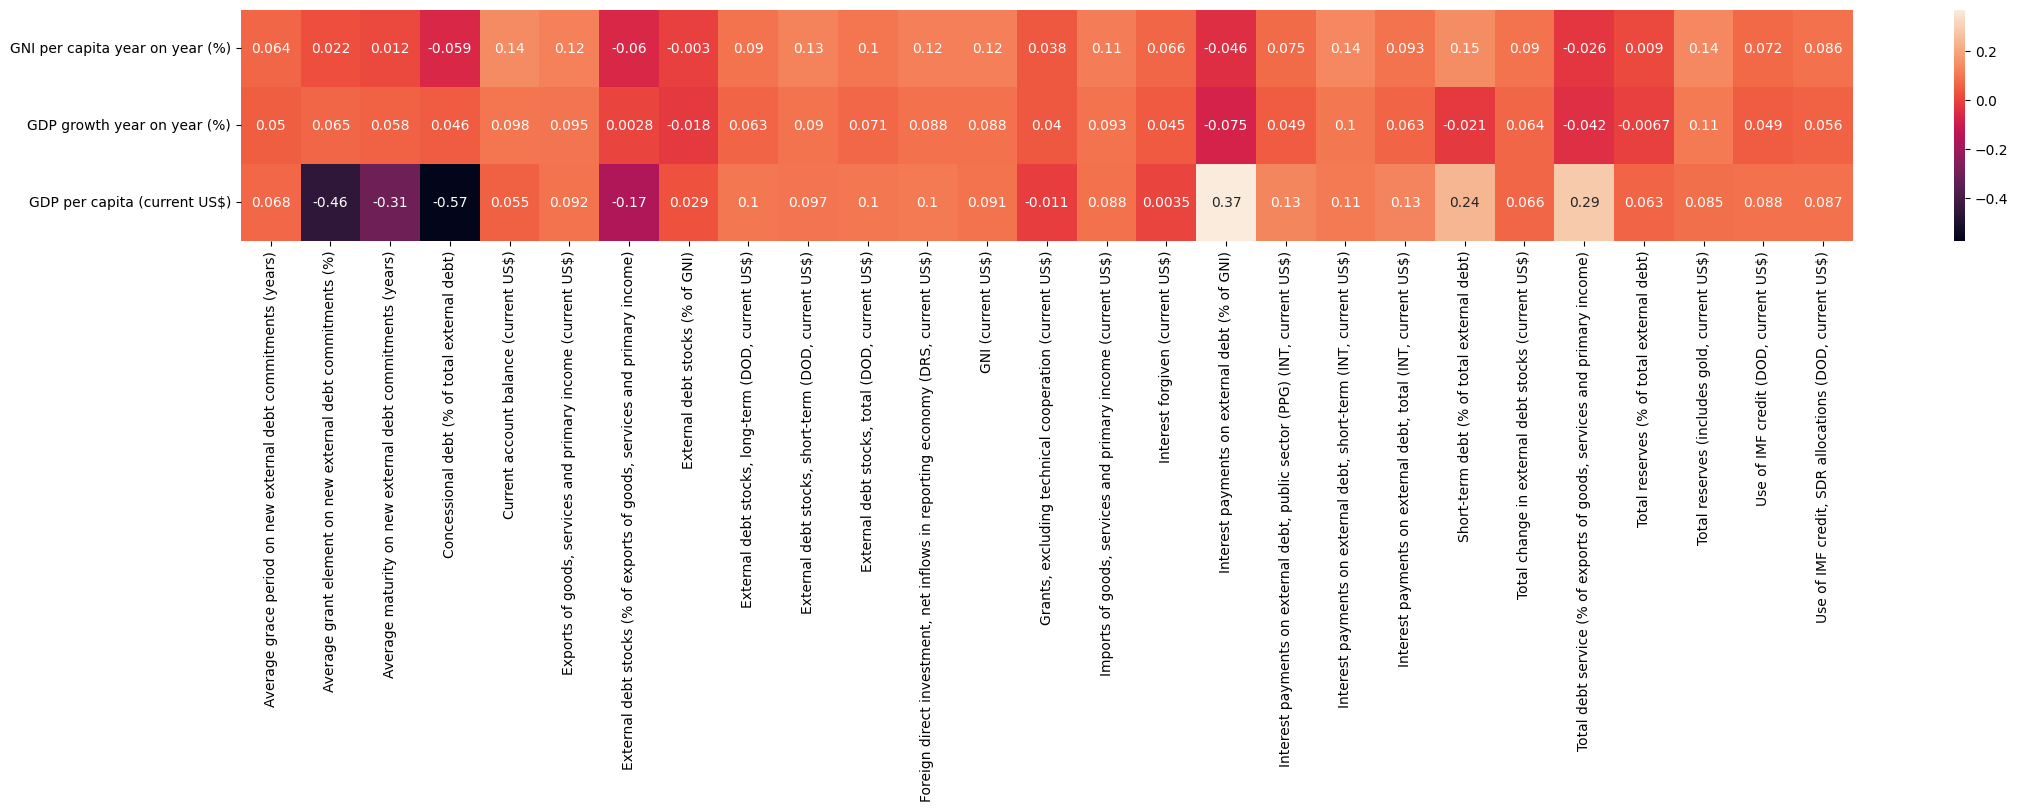

In [101]:
# Make an empty array that matches the dimensions of a the correlation table for an individual year so that we can add up the data
total_arr = []
# An array full of 21's (The total number of years) so that we can divide to get the average
total_nan_arr = []

# Fills in arrays with 0's or 21's
for num in range(30):
    total_arr.append(np.zeros(30))
    total_nan_arr.append(np.full(30, 21))

# Converts arrays to numpy arrays
total_arr = np.array(total_arr)
total_nan_arr = np.array(total_nan_arr)

# Loops through all years (2000 to 2020)
for curr_year in range(2000,2021):
    # Gets the correlation table for the current year then converts the dataframe to a numpy array
    curr_corr_table = get_corr_table_for_year(curr_year).to_numpy()
    
    # Sets the initial value of the row's index at 0
    row_index = 0 

    for row in curr_corr_table:
        # Sets the value of the current values index at 0
        value_index = 0
        
        for specific_comparison in row:

            # If the value is not empty (denoted in the array by NaN) we add it to its corresponding correlation value
            if not math.isnan(specific_comparison):
                total_arr[row_index][value_index] += specific_comparison   
            
            else:
                # For every empty value we minus one from its corresponding averaging value as less numbers will be added to the total value of all the categories
                # We can use the row index and value index since the both arrays have the same dimensions
                total_nan_arr[row_index][value_index] -= 1
            
            value_index += 1

        row_index += 1

final_arr = []
for final_i in range(3):
    final_arr.append(total_arr[final_i]/total_nan_arr[final_i])

final_arr = np.array(final_arr)

# Gets the index for the new numpy array
index = get_corr_table_for_year(2000).index
total_corr = pd.DataFrame(data=final_arr[:,3:],columns=index[3:],index=index[:3])

plt.figure(figsize=(26,3))
sns.heatmap(total_corr, annot=True)
plt.show()

In [15]:
i = 1
for year_array in df_categories_array:
    print(year_array[0])
    for categoryx in year_array:
        print(i)
        i+=1
    break

[ 1.00000000e+00  4.71104212e-01  7.49831547e-01  2.53232035e-01
 -1.54708595e-01 -5.18282441e-03  2.67889818e-01  9.62895908e-02
  2.85780093e-02  3.56411128e-02  3.19402620e-02  3.72835871e-02
  2.02521781e-02  1.99105215e-02  2.63003695e-03 -1.18417401e-01
  8.06725621e-02  3.42715027e-02  3.35832178e-02  4.10115012e-02
 -2.12071951e-01 -6.59486420e-03  1.61398882e-01 -1.77224360e-01
 -6.12221258e-03  1.13300988e-02 -5.44312772e-03  1.00000000e+00
  4.71104212e-01  7.49831547e-01  2.53232035e-01 -1.54708595e-01
 -5.18282441e-03  2.67889818e-01  9.62895908e-02  2.85780093e-02
  3.56411128e-02  3.19402620e-02  3.72835871e-02  2.02521781e-02
  1.99105215e-02  2.63003695e-03 -1.18417401e-01  8.06725621e-02
  3.42715027e-02  3.35832178e-02  4.10115012e-02 -2.12071951e-01
 -6.59486420e-03  1.61398882e-01 -1.77224360e-01 -6.12221258e-03
  1.13300988e-02 -5.44312772e-03  4.78040156e-01  3.37881055e-01
  5.05119447e-01  2.67804419e-01 -1.51011106e-01 -2.76566310e-04
  2.35020517e-01  7.76054

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']


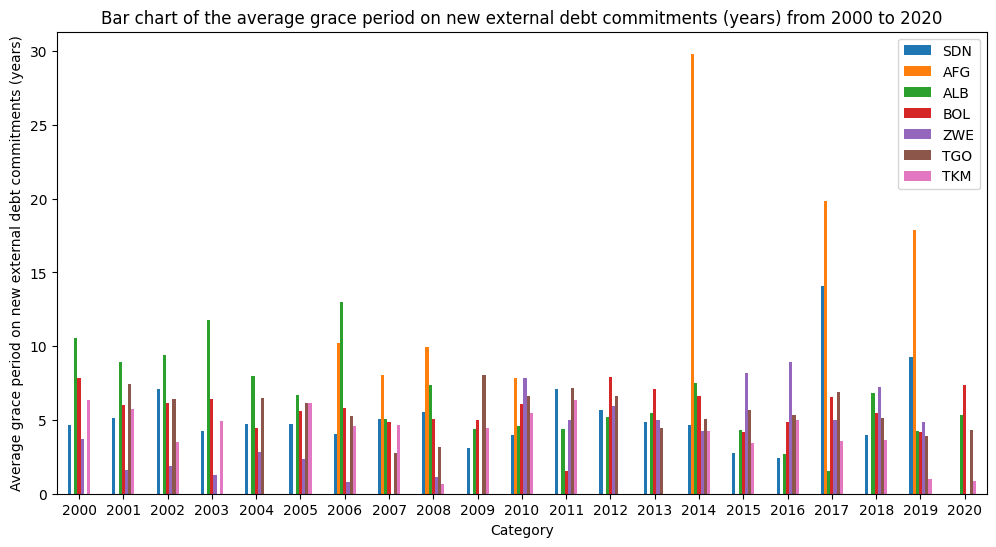

In [17]:
def get_barchart(countries):
    barchart_data = {}
    country1 = countries[0]
    countries_index = country1[0]
    print(countries_index)
    for category in country1[1]:
        for country in countries:  
            barchart_data[country[2]] = country[1][category]
            # break
            if country == countries[-1]:
                df = pd.DataFrame(barchart_data,index=countries_index)
                df.plot.bar(xlabel='Category',ylabel=category,rot=0, figsize=(12,6), title=f"Bar chart of the {category.lower()} from 2000 to 2020")
                barchart_data = {}
countries_codes = ['SDN','AFG','ALB','BOL','ZWE','TGO','TKM']
barchart_input = []
for country_code in countries_codes:
    input_value = split_data_up(country_code,['Average grace period on new external debt commitments (years)'])
    barchart_input.append(input_value)
get_barchart(barchart_input)